In [106]:
import numpy as np
import pandas as pd
# import sqlite3 as sql
# import os
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.graph_objs as go
from xgboost import XGBRegressor
import shap

from dotenv import load_dotenv
import sys
sys.path.insert(0, '../data_prep')
from sqlite_utils import select_statement_to_df

In [107]:
load_dotenv()

True

In [108]:
eligible_watchlist_query = """

WITH BASE_TABLE AS (
    
      SELECT
      
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.FILM_GENRE
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
      
      FROM ALL_FILMS a
      LEFT JOIN CONTENT_TYPE b
      ON a.FILM_ID = b.FILM_ID
      LEFT JOIN FILM_TITLE c
      ON a.FILM_ID = c.FILM_ID
      LEFT JOIN FILM_GENRE d
      ON a.FILM_ID = d.FILM_ID
      LEFT JOIN FILM_LETTERBOXD_STATS e
      ON a.FILM_ID = e.FILM_ID
      LEFT JOIN PERSONAL_RATING f
      ON a.FILM_ID = f.FILM_ID
      
      WHERE CONTENT_TYPE = 'movie'
      
    )
        
    , GENRE_SCORE AS (
    
      SELECT
    
        FILM_GENRE
        ,AVG(FILM_RATING) AS MEAN_RATING
        ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
        ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
        ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
        ,COUNT(*) AS FILM_COUNT
        ,SUM(RATED) AS RATED_FILM_COUNT
        ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
      FROM BASE_TABLE
    
      GROUP BY FILM_GENRE
    
    )
    
    , STREAMING_CONCAT AS (
    
      SELECT
        
        FILM_ID
        ,GROUP_CONCAT(STREAMING_SERVICE_FULL, ', ') AS STREAMING_SERVICES
        ,MIN(CASE WHEN STREAMING_SERVICE_ABBR = 'rent' THEN PRICE END) AS MIN_RENTAL_PRICE
      
      FROM FILM_STREAMING_SERVICES
      
      GROUP BY FILM_ID
    
    )
   
    SELECT

      a.FILM_ID
      ,b.FILM_TITLE
      ,b.LETTERBOXD_URL
      ,c.FILM_WATCH_COUNT
      ,c.FILM_TOP_250
      ,c.FILM_RATING
      ,c.FILM_LIKES_COUNT
      ,c.FILM_FAN_COUNT
      ,CASE WHEN d.FILM_ID IS NULL THEN 'No' ELSE 'Yes' END AS STREAMING
      ,h.STREAMING_SERVICES
      ,CASE WHEN h.MIN_RENTAL_PRICE IS NULL THEN 'No' ELSE 'Yes' END AS RENTABLE
      ,CASE WHEN d.FILM_ID IS NOT NULL OR h.MIN_RENTAL_PRICE IS NOT NULL THEN 'Yes' ELSE 'No' END AS WATCHABLE
      ,h.MIN_RENTAL_PRICE
      ,e.FILM_RUNTIME
      ,i.FILM_DECADE
      ,i.FILM_YEAR
      ,f.FILM_GENRE
      ,COALESCE(g.VARIANCE_SCORE, 0) AS GENRE_SCORE
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN FILM_TITLE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILMS_AVAILABLE_TO_STREAM d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_RUNTIME e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN FILM_GENRE f
    ON a.FILM_ID = f.FILM_ID
    LEFT JOIN GENRE_SCORE g
    ON f.FILM_GENRE = g.FILM_GENRE
    LEFT JOIN STREAMING_CONCAT h
    ON a.FILM_ID = h.FILM_ID
    LEFT JOIN FILM_YEAR i
    ON a.FILM_ID = i.FILM_ID
    LEFT JOIN FILM_COLLECTIONS_VALID j
    ON a.FILM_ID = j.FILM_ID
    LEFT JOIN COLLECTION_STATS k
    ON j.COLLECTION_ID = k.COLLECTION_ID
    
    WHERE COALESCE(j.COLLECTION_NUM, 0) <= COALESCE(k.MAX_WATCHED, 0) + 1;

"""

In [233]:
keyword_query = """

WITH BASE_TABLE AS (
    
    SELECT
    
        a.FILM_ID
        ,c.FILM_TITLE
        ,d.KEYWORD
        ,d.KEYWORD_ID
        ,e.FILM_RATING
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NOT NULL THEN 1 ELSE 0 END AS RATED
    
    FROM ALL_FEATURE_FILMS a
    LEFT JOIN CONTENT_TYPE b
    ON a.FILM_ID = b.FILM_ID
    LEFT JOIN FILM_TITLE c
    ON a.FILM_ID = c.FILM_ID
    LEFT JOIN FILM_KEYWORDS d
    ON a.FILM_ID = d.FILM_ID
    LEFT JOIN FILM_LETTERBOXD_STATS e
    ON a.FILM_ID = e.FILM_ID
    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID
    
    WHERE b.CONTENT_TYPE = 'movie'
    
    )
    
, SCORE_TABLE AS (

    SELECT

    KEYWORD_ID
    ,KEYWORD
    ,AVG(FILM_RATING) AS MEAN_RATING
    ,AVG(FILM_RATING_SCALED) AS MY_MEAN_RATING
    ,AVG(FILM_RATING_SCALED) - AVG(FILM_RATING) AS MY_VARIANCE
    ,((AVG(FILM_RATING_SCALED) - AVG(FILM_RATING)) * ((SUM(RATED)+0.0)/COUNT(*))) AS VARIANCE_SCORE
    ,COUNT(*) AS KEYWORD_COUNT
    ,SUM(RATED) AS MY_RATING_COUNT
    ,(SUM(RATED)+0.0)/COUNT(*) AS SCALER
    
    FROM BASE_TABLE
    
    GROUP BY KEYWORD
    
    HAVING KEYWORD_COUNT >= 30
    AND SCALER >= 0.2
    AND MY_RATING_COUNT >= 3
    --ORDER BY MEAN_RATING DESC
    --ORDER BY KEYWORD_COUNT DESC
    --ORDER BY MY_VARIANCE DESC
    --ORDER BY VARIANCE_SCORE DESC
    --ORDER BY MY_MEAN_RATING DESC
    --ORDER BY VARIANCE_SCORE DESC
)

SELECT
    a.FILM_ID
    ,a.KEYWORD_ID
    ,b.KEYWORD
    
FROM FILM_KEYWORDS a
LEFT JOIN SCORE_TABLE b
ON a.KEYWORD_ID = b.KEYWORD_ID

WHERE b.KEYWORD_ID IS NOT NULL

"""

In [234]:
my_rating_query = """

    SELECT
         FILM_ID
        ,FILM_RATING_SCALED
    FROM PERSONAL_RATING

"""

In [300]:
director_rating_query = """

WITH BASE_TABLE AS (

    SELECT

        a.FILM_ID
        ,d.FILM_TITLE
        ,b.PERSON_ID
        ,e.PERSON_NAME AS DIRECTOR_NAME
        ,CASE WHEN c.FILM_ID IS NULL THEN 0 ELSE 1 END AS WATCHED
        ,f.FILM_RATING_SCALED
        ,CASE WHEN f.FILM_RATING_SCALED IS NULL THEN 0 ELSE 1 END AS RATED

    FROM ALL_FEATURE_FILMS a

    LEFT JOIN FILM_CREW b
    ON a.FILM_ID = b.FILM_ID

    LEFT JOIN WATCHED c
    ON a.FILM_ID = c.FILM_ID

    LEFT JOIN FILM_TITLE d
    ON a.FILM_ID = d.FILM_ID

    LEFT JOIN PERSON_INFO e
    ON b.PERSON_ID = e.PERSON_ID

    LEFT JOIN PERSONAL_RATING f
    ON a.FILM_ID = f.FILM_ID

    WHERE b.JOB = 'Director'
        
    )
      
, DIRECTOR_RATINGS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,SUM(WATCHED) AS FILMS_WATCHED
      ,AVG(WATCHED) AS PERCENT_WATCHED
      ,AVG(FILM_RATING_SCALED) AS MEAN_RATING
      ,SUM(RATED) AS FILMS_RATED
      ,AVG(RATED) AS PERCENT_RATED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME

    HAVING TOTAL_FILMS >= 3
    AND FILMS_WATCHED > 1
    AND FILMS_RATED > 1
    AND MEAN_RATING NOT NULL
    AND PERCENT_RATED >= .2
    
 	)
, DIRECTOR_WATCH_STATS AS (

	SELECT
      
       PERSON_ID
	  ,DIRECTOR_NAME
      ,COUNT(*) AS TOTAL_FILMS
      ,AVG(WATCHED) AS PERCENT_WATCHED
      
    FROM BASE_TABLE
    
    GROUP BY PERSON_ID, DIRECTOR_NAME
    
 	)

, MEAN_RATING AS ( SELECT AVG(MEAN_RATING)AS MEAN_TOTAL_RATING FROM DIRECTOR_RATINGS )

, FILM_DIRECTOR_LEVEL AS (

	SELECT
		
		 a.FILM_ID
		,a.FILM_TITLE
		,a.PERSON_ID
		,a.DIRECTOR_NAME
		,COALESCE(b.MEAN_RATING, (SELECT MEAN_TOTAL_RATING FROM MEAN_RATING)) AS DIRECTOR_MEAN_RATING
		,COALESCE(c.TOTAL_FILMS, 0) AS DIRECTOR_TOTAL_FILMS
		,COALESCE(c.PERCENT_WATCHED, 0) AS DIRECTOR_PERCENT_WATCHED
		
	 FROM BASE_TABLE a
	 LEFT JOIN DIRECTOR_RATINGS b 
	 ON a.PERSON_ID = b.PERSON_ID
	 LEFT JOIN DIRECTOR_WATCH_STATS c
	 ON a.PERSON_ID = c.PERSON_ID
	 
	 )
	 
SELECT
	
	 FILM_ID
	,AVG(DIRECTOR_MEAN_RATING) AS DIRECTOR_MEAN_RATING
	,AVG(DIRECTOR_TOTAL_FILMS) AS DIRECTOR_TOTAL_FILMS
	,AVG(DIRECTOR_PERCENT_WATCHED) AS DIRECTOR_PERCENT_WATCHED

FROM FILM_DIRECTOR_LEVEL

GROUP BY FILM_ID, FILM_TITLE

"""

In [301]:
eligible_watchlist_df = select_statement_to_df(eligible_watchlist_query)
eligible_watchlist_df.head()

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,STREAMING_SERVICES,RENTABLE,WATCHABLE,MIN_RENTAL_PRICE,FILM_RUNTIME,FILM_DECADE,FILM_YEAR,FILM_GENRE,GENRE_SCORE
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,NaN,3.57,125647,611,Yes,Amazon Prime Video,No,Yes,NaN,104,1990s,1995,fantasy,0.002118
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,NaN,3.41,13180,98,Yes,NowTV,No,Yes,NaN,119,1980s,1987,drama,0.009392
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,NaN,3.96,133499,6804,No,Rental,Yes,Yes,3.49,96,2000s,2002,drama,0.009392
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,NaN,3.59,13089,200,No,Rental,Yes,Yes,3.49,102,1980s,1980,horror,0.042387
4,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,NaN,2.74,8886,3,Yes,Netflix,No,Yes,NaN,71,2020s,2020,comedy,-0.016502


In [302]:
director_rating_df = select_statement_to_df(director_rating_query)
director_rating_df.head()

,FILM_ID,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED
0,f_0001C,3.546866,7.0,0.142857
1,f_0002q,3.546866,1.0,0.000000
2,f_0009w,3.546866,5.0,0.200000
3,f_000DQ,3.546866,5.0,0.400000
4,f_000IG,3.546866,10.0,0.500000


In [303]:
eligible_watchlist_df2 = eligible_watchlist_df.merge(director_rating_df, how='left', on='FILM_ID')
eligible_watchlist_df2.head()

,FILM_ID,FILM_TITLE,LETTERBOXD_URL,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,STREAMING_SERVICES,...,WATCHABLE,MIN_RENTAL_PRICE,FILM_RUNTIME,FILM_DECADE,FILM_YEAR,FILM_GENRE,GENRE_SCORE,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED
0,f_01ZLI,Jumanji,https://boxd.it/1ZLI,701566,NaN,3.57,125647,611,Yes,Amazon Prime Video,...,Yes,NaN,104,1990s,1995,fantasy,0.002118,3.546866,8.0,0.500000
1,f_01UTC,Fatal Attraction,https://boxd.it/1UTC,83493,NaN,3.41,13180,98,Yes,NowTV,...,Yes,NaN,119,1980s,1987,drama,0.009392,3.546866,9.0,0.222222
2,f_020E4,Punch-Drunk Love,https://boxd.it/20E4,411414,NaN,3.96,133499,6804,No,Rental,...,Yes,3.49,96,2000s,2002,drama,0.009392,4.188379,9.0,1.000000
3,f_01TBi,Altered States,https://boxd.it/1TBi,50793,NaN,3.59,13089,200,No,Rental,...,Yes,3.49,102,1980s,1980,horror,0.042387,3.546866,15.0,0.133333
4,f_0t4EQ,Death to 2020,https://boxd.it/t4EQ,77786,NaN,2.74,8886,3,Yes,Netflix,...,Yes,NaN,71,2020s,2020,comedy,-0.016502,3.546866,1.0,1.000000


In [304]:
genre_df = eligible_watchlist_df2.copy()[['FILM_ID', 'FILM_GENRE']]
genre_df['COUNT'] = 1
genre_df.head()

,FILM_ID,FILM_GENRE,COUNT
0,f_01ZLI,fantasy,1
1,f_01UTC,drama,1
2,f_020E4,drama,1
3,f_01TBi,horror,1
4,f_0t4EQ,comedy,1


In [305]:
genre_df_wide = pd.pivot_table(genre_df, values='COUNT', index=['FILM_ID'], columns=['FILM_GENRE']).fillna(0).reset_index()
genre_df_wide

FILM_GENRE,FILM_ID,action,adventure,animation,comedy,crime,drama,family,fantasy,history,horror,mystery,none,romance,science-fiction,thriller,war,western
0,f_0001C,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_0002q,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_0009w,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_000DQ,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_000IG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640,f_0zd5M,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7641,f_0zdfW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7642,f_0zl06,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7643,f_0zrn6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [322]:
eligible_watchlist_df3 = eligible_watchlist_df2[['FILM_ID', 'FILM_TITLE', 'FILM_WATCH_COUNT', 'FILM_TOP_250', 'FILM_RATING', 'FILM_LIKES_COUNT', 'FILM_FAN_COUNT', 'FILM_RUNTIME', 'FILM_YEAR', 'DIRECTOR_MEAN_RATING', 'DIRECTOR_TOTAL_FILMS', 'DIRECTOR_PERCENT_WATCHED']].merge(genre_df_wide, how='left', on='FILM_ID')
eligible_watchlist_df3.head()

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,fantasy,history,horror,mystery,none,romance,science-fiction,thriller,war,western
0,f_01ZLI,Jumanji,701566,NaN,3.57,125647,611,104,1995,3.546866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_01UTC,Fatal Attraction,83493,NaN,3.41,13180,98,119,1987,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_020E4,Punch-Drunk Love,411414,NaN,3.96,133499,6804,96,2002,4.188379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_01TBi,Altered States,50793,NaN,3.59,13089,200,102,1980,3.546866,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_0t4EQ,Death to 2020,77786,NaN,2.74,8886,3,71,2020,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [323]:
keyword_df = select_statement_to_df(keyword_query)
keyword_df['COUNT'] = 1
keyword_df.head()

,FILM_ID,KEYWORD_ID,KEYWORD,COUNT
0,f_0C6uQ,256183,supernatural horror,1
1,f_0C6uQ,296608,teenager,1
2,f_0pZCY,13031,creature,1
3,f_0pZCY,296608,teenager,1
4,f_0mIIu,256183,supernatural horror,1


In [324]:
keyword_df_wide = pd.pivot_table(keyword_df, values='COUNT', index=['FILM_ID'], columns=['KEYWORD']).fillna(0).reset_index()
keyword_df_wide

KEYWORD,FILM_ID,alien life-form,android,anti hero,brother brother relationship,cannibal,creature,curse,cyberpunk,decapitation,...,space opera,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods
0,f_0009w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_000uu,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_000xe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,f_002Pa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_003NY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,f_0y3mc,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,f_0zPbe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,f_0zTCy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1649,f_0zUWk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [325]:
eligible_watchlist_df4 = eligible_watchlist_df3.merge(keyword_df_wide, how='left', on='FILM_ID')

In [326]:
eligible_watchlist_df4['FILM_TOP_250'] = eligible_watchlist_df4['FILM_TOP_250'].fillna(266)
eligible_watchlist_df4['FILM_RATING'] = eligible_watchlist_df4['FILM_RATING'].fillna(2.0)
eligible_watchlist_df5 = eligible_watchlist_df4.fillna(0)

In [327]:
eligible_watchlist_df5

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,space opera,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods
0,f_01ZLI,Jumanji,701566,266.0,3.57,125647,611,104,1995,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f_01UTC,Fatal Attraction,83493,266.0,3.41,13180,98,119,1987,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f_020E4,Punch-Drunk Love,411414,266.0,3.96,133499,6804,96,2002,4.188379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_01TBi,Altered States,50793,266.0,3.59,13089,200,102,1980,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_0t4EQ,Death to 2020,77786,266.0,2.74,8886,3,71,2020,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640,f_01QLa,All the Real Girls,8255,266.0,3.56,1686,42,108,2003,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7641,f_03MO4,Prince Avalanche,23131,266.0,3.22,3632,23,94,2013,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7642,f_00mIo,The Sitter,43026,266.0,2.44,3462,10,81,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7643,f_016g6,Your Highness,51938,266.0,2.18,3443,13,102,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [328]:
my_rating_df = select_statement_to_df(my_rating_query)
my_rating_df

,FILM_ID,FILM_RATING_SCALED
0,f_006YA,4.628378
1,f_006YK,4.921053
2,f_0070G,4.835526
3,f_0071a,4.722973
4,f_0071k,4.014000
...,...,...
755,f_0w1Im,3.552198
756,f_0w4Zg,2.993976
757,f_0waRi,3.240964
758,f_0xjfE,2.100000


In [329]:
rating_features_df = eligible_watchlist_df5.merge(my_rating_df, how='left', on='FILM_ID')
rating_features_df

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED
0,f_01ZLI,Jumanji,701566,266.0,3.57,125647,611,104,1995,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.543333
1,f_01UTC,Fatal Attraction,83493,266.0,3.41,13180,98,119,1987,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.814000
2,f_020E4,Punch-Drunk Love,411414,266.0,3.96,133499,6804,96,2002,4.188379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.123494
3,f_01TBi,Altered States,50793,266.0,3.59,13089,200,102,1980,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.110000
4,f_0t4EQ,Death to 2020,77786,266.0,2.74,8886,3,71,2020,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7640,f_01QLa,All the Real Girls,8255,266.0,3.56,1686,42,108,2003,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7641,f_03MO4,Prince Avalanche,23131,266.0,3.22,3632,23,94,2013,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7642,f_00mIo,The Sitter,43026,266.0,2.44,3462,10,81,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
7643,f_016g6,Your Highness,51938,266.0,2.18,3443,13,102,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [330]:
rating_features_df.describe()

,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,...,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED
count,7.645000e+03,7645.000000,7645.000000,7.645000e+03,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,...,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,7645.000000,732.000000
mean,1.292767e+05,262.311707,3.186144,3.067570e+04,911.787574,106.210988,1998.454676,3.548120,6.369993,0.255425,...,0.003924,0.004317,0.004971,0.008502,0.004709,0.004709,0.006802,0.005232,0.008110,3.314685
std,2.689578e+05,25.816935,0.573602,8.513793e+04,4116.427729,21.406755,20.421691,0.172506,7.026512,0.309561,...,0.062524,0.065563,0.070331,0.091821,0.068465,0.068465,0.082198,0.072149,0.089695,0.928278
min,1.400000e+01,1.000000,0.840000,1.000000e+00,0.000000,60.000000,1911.000000,1.423790,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.375000
25%,8.426000e+03,266.000000,2.800000,1.271000e+03,5.000000,92.000000,1988.000000,3.546866,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.817771
50%,3.144500e+04,266.000000,3.230000,5.068000e+03,36.000000,102.000000,2004.000000,3.546866,4.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.388736
75%,1.151220e+05,266.000000,3.610000,2.046100e+04,271.000000,117.000000,2015.000000,3.546866,8.000000,0.466667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.963000
max,2.585488e+06,266.000000,4.580000,1.492578e+06,103265.000000,432.000000,2023.000000,4.874467,40.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [331]:
rated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].notnull()].reset_index(drop=True)
rated_features

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED
0,f_01ZLI,Jumanji,701566,266.0,3.57,125647,611,104,1995,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.543333
1,f_01UTC,Fatal Attraction,83493,266.0,3.41,13180,98,119,1987,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.814000
2,f_020E4,Punch-Drunk Love,411414,266.0,3.96,133499,6804,96,2002,4.188379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.123494
3,f_01TBi,Altered States,50793,266.0,3.59,13089,200,102,1980,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.110000
4,f_0099A,The Skin I Live In,231526,266.0,3.84,57781,1179,120,2011,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.942771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,f_00DvG,When the Lights Went Out,1453,266.0,2.47,113,1,86,2012,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.263333
728,f_01dZi,Nine Dead,5166,266.0,2.36,399,2,98,2010,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.104167
729,f_0tw4c,The Whale,439189,266.0,3.74,132966,1686,116,2022,3.797094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.864458
730,f_01Q1m,Eden Lake,59192,266.0,3.28,10036,78,91,2008,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.643333


In [332]:
unrated_features = rating_features_df[rating_features_df['FILM_RATING_SCALED'].isnull()].reset_index(drop=True)
unrated_features

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED
0,f_0t4EQ,Death to 2020,77786,266.0,2.74,8886,3,71,2020,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,f_02aNK,The Godfather,1400909,6.0,4.54,555741,44323,175,1972,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,f_02aNq,The Godfather: Part II,785419,5.0,4.54,279663,17164,202,1974,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,f_02axi,Seven Samurai,284104,9.0,4.51,107662,7437,207,1954,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,f_0azpY,Spider-Man: Into the Spider-Verse,2112250,16.0,4.44,1090676,59458,117,2018,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6908,f_01QLa,All the Real Girls,8255,266.0,3.56,1686,42,108,2003,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6909,f_03MO4,Prince Avalanche,23131,266.0,3.22,3632,23,94,2013,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6910,f_00mIo,The Sitter,43026,266.0,2.44,3462,10,81,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6911,f_016g6,Your Highness,51938,266.0,2.18,3443,13,102,2011,3.515169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [333]:
non_features = ['FILM_ID',
                'FILM_TITLE',
                'FILM_RATING_SCALED',
                'FILM_TOP_250',
                'FILM_RUNTIME'
                ]


model_features = [x for x in unrated_features.columns if x not in non_features]

In [334]:
delete_cols = []
for col in model_features:
    col_mean = rated_features[col].mean()
    if col_mean <= .01:
        delete_cols.append(col)
model_features = [x for x in model_features if x not in delete_cols]

In [335]:
target = ['FILM_RATING_SCALED']

In [336]:
X_train = rated_features[model_features]
y_train = rated_features[target]

In [337]:
X_train

,FILM_WATCH_COUNT,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_YEAR,DIRECTOR_MEAN_RATING,DIRECTOR_TOTAL_FILMS,DIRECTOR_PERCENT_WATCHED,action,adventure,...,space opera,supernatural horror,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods
0,701566,3.57,125647,611,1995,3.546866,8.0,0.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,83493,3.41,13180,98,1987,3.546866,9.0,0.222222,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,411414,3.96,133499,6804,2002,4.188379,9.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50793,3.59,13089,200,1980,3.546866,15.0,0.133333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,231526,3.84,57781,1179,2011,3.546866,13.0,0.076923,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,1453,2.47,113,1,2012,3.546866,1.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728,5166,2.36,399,2,2010,3.546866,1.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
729,439189,3.74,132966,1686,2022,3.797094,8.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,59192,3.28,10036,78,2008,3.546866,2.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [338]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: >

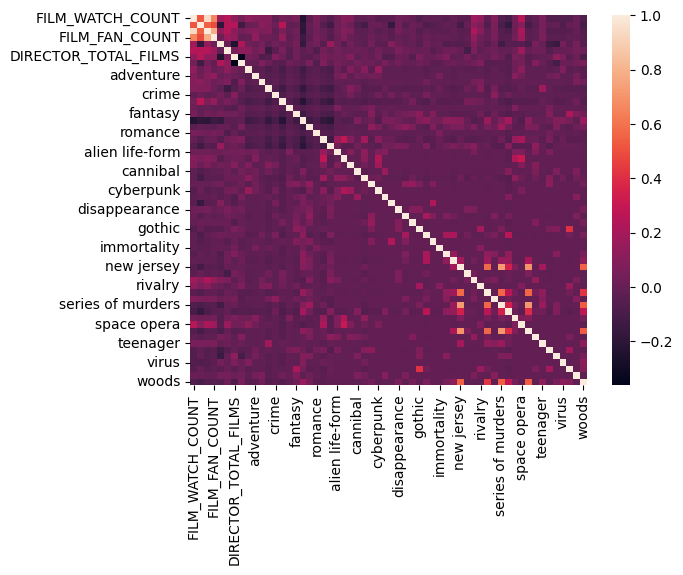

In [339]:
sns.heatmap(X_train.corr())

In [349]:
X_pred = unrated_features[model_features]
pred_df = unrated_features.copy()
pred_df['PREDICTED_SCORE'] = xgb_model.predict(X_pred)
pred_df[pred_df['DIRECTOR_MEAN_RATING'] != pred_df.loc[0, 'DIRECTOR_MEAN_RATING']].sort_values('PREDICTED_SCORE', ascending=False).head(50)
pred_df.sort_values('PREDICTED_SCORE', ascending=False).head(20)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED,PREDICTED_SCORE
506,f_00ham,Looper,500583,266.0,3.52,103020,402,118,2012,4.473605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.171919
13,f_02aHW,The Silence of the Lambs,1601483,68.0,4.31,606787,22736,119,1991,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.017694
135,f_05xme,Star Wars: The Last Jedi,1329488,266.0,3.06,272574,2590,152,2017,4.473605,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.004869
345,f_09X0m,The Witch,908706,266.0,3.87,304606,9742,92,2015,4.798542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,4.897040
90,f_02192,Cloverfield,384187,266.0,3.34,70588,890,85,2008,4.317127,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.888477
108,f_04VZ8,Interstellar,2151537,82.0,4.30,934789,103265,169,2014,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.881248
257,f_08FE2,War for the Planet of the Apes,398580,266.0,3.68,83051,719,140,2017,4.317127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,4.871019
1293,f_00Msm,Incendies,173861,91.0,4.28,62083,4040,131,2010,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.855474
1304,f_029b6,Paths of Glory,189275,52.0,4.33,64985,1446,88,1957,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.842987
14,f_029Nu,The Shining,1835867,111.0,4.26,735605,32742,144,1980,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,4.822019


In [341]:
feat_imp_df = pd.DataFrame()
feat_imp_df['FEATURE_NAME'] = xgb_model.feature_names_in_
feat_imp_df['FEATURE_IMPORTANCE'] = xgb_model.feature_importances_
feat_imp_df = feat_imp_df.sort_values('FEATURE_IMPORTANCE', ascending=False).reset_index(drop=True)

<Axes: xlabel='FEATURE_IMPORTANCE', ylabel='FEATURE_NAME'>

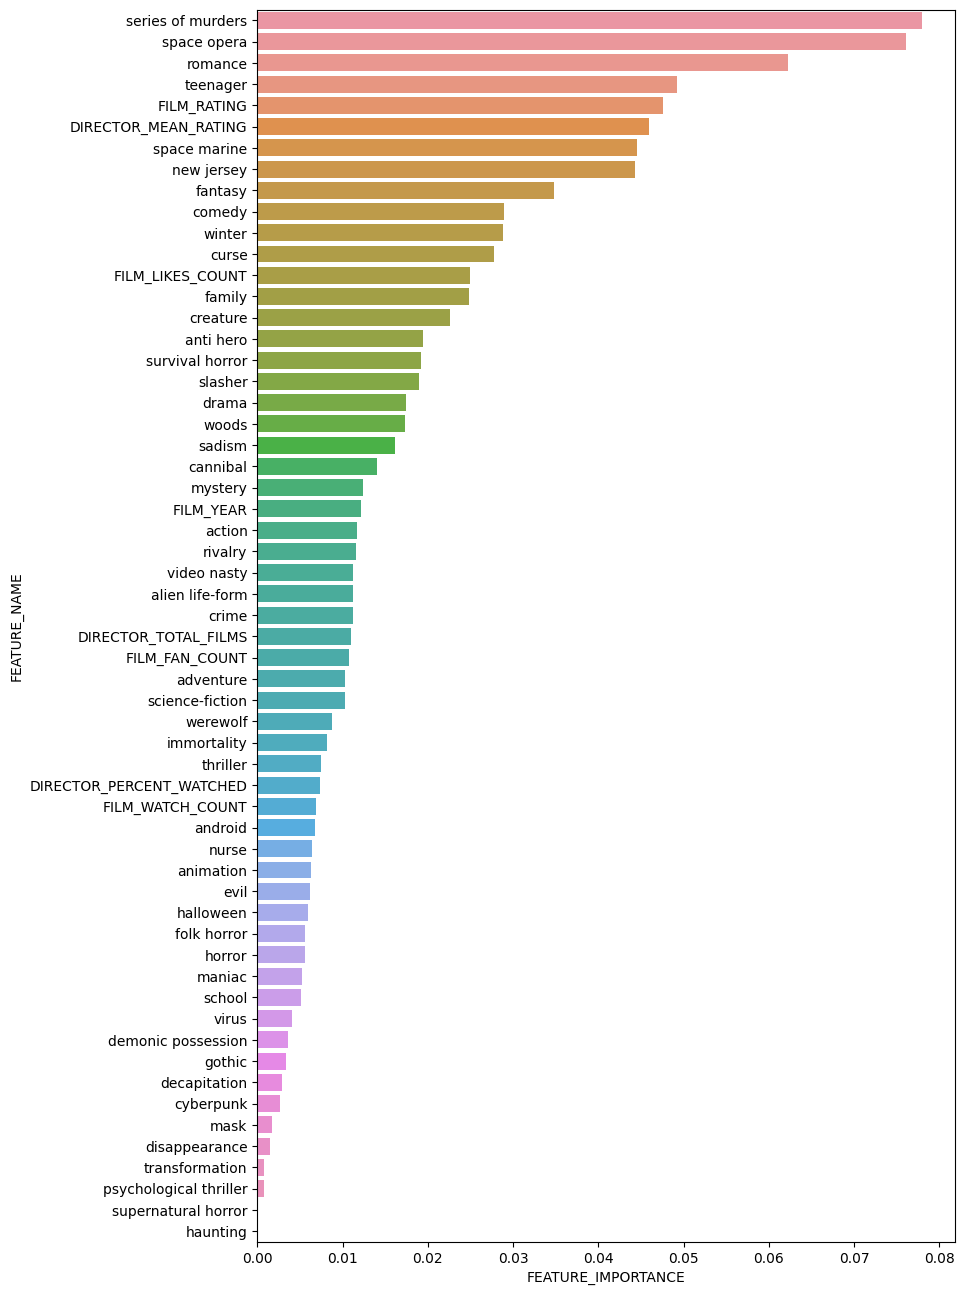

In [342]:
fig = plt.figure(figsize=(9, 16))
sns.barplot(data=feat_imp_df, x='FEATURE_IMPORTANCE', y='FEATURE_NAME')

In [343]:
pred = xgb_model.predict(X_pred, output_margin=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_pred)
# shap_interaction_values = explainer.shap_interaction_values(X_pred)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


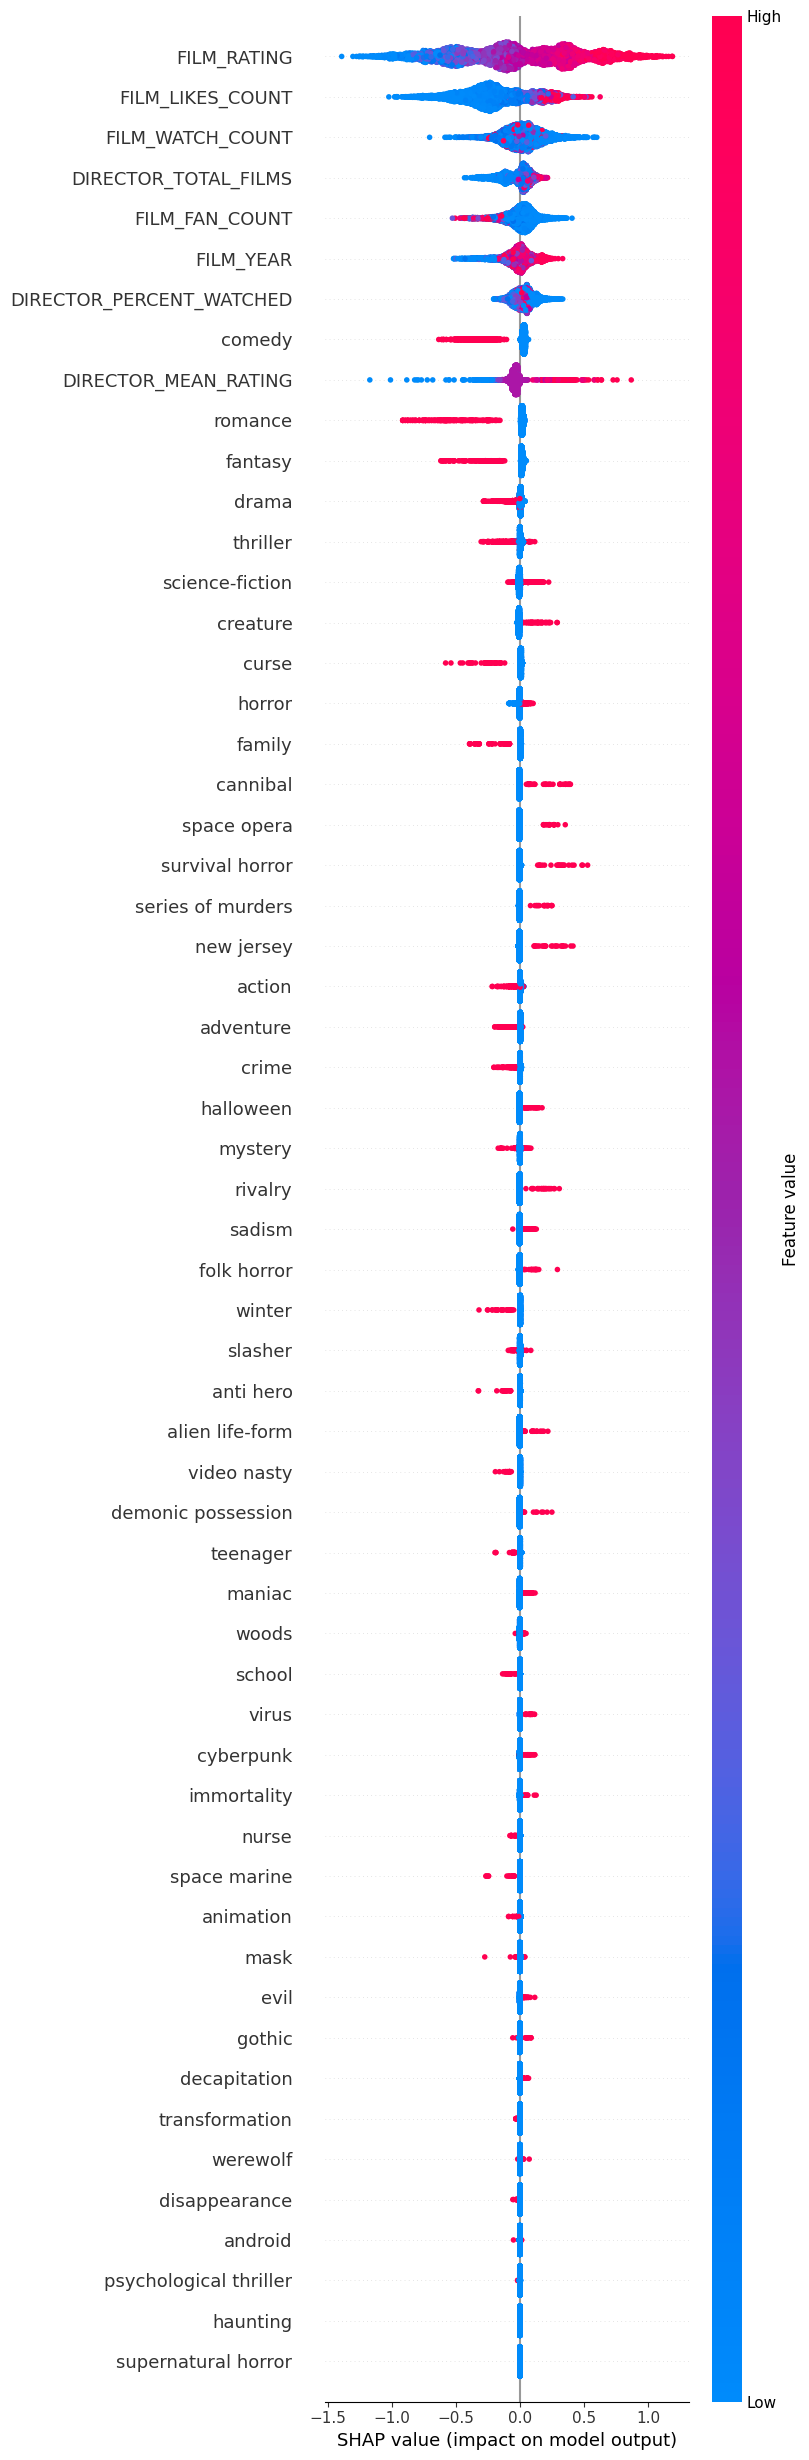

In [344]:
shap.summary_plot(shap_values, X_pred, max_display=X_pred.shape[1])

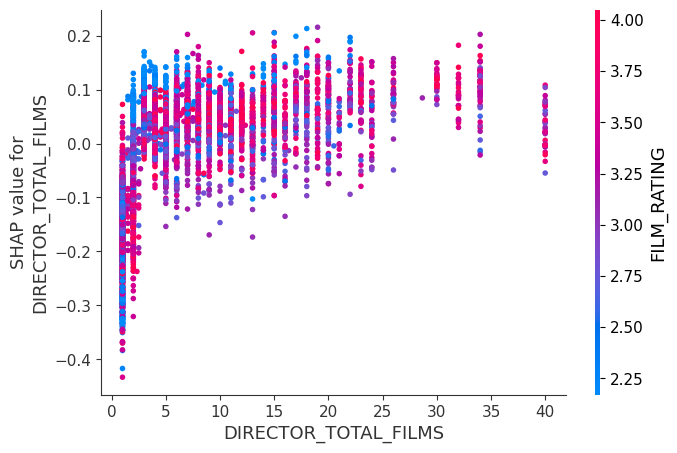

In [346]:
shap.dependence_plot('DIRECTOR_TOTAL_FILMS', shap_values, X_pred, interaction_index='FILM_RATING')

In [208]:
shap.initjs()

In [367]:
film_index = 5293
shap.force_plot(explainer.expected_value, shap_values[film_index, :], X_pred.iloc[film_index, :])

In [366]:
pred_df.sort_values('PREDICTED_SCORE', ascending=True).head(10)

,FILM_ID,FILM_TITLE,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,FILM_RUNTIME,FILM_YEAR,DIRECTOR_MEAN_RATING,...,survival horror,teenager,transformation,video nasty,virus,werewolf,winter,woods,FILM_RATING_SCALED,PREDICTED_SCORE
5293,f_0wYFG,Hunters,28,266.0,2.00,2,0,95,2021,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.395646
4773,f_0BMHg,Get Away If You Can,144,266.0,2.25,6,0,90,2022,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.489079
5294,f_0BE8s,Death Hunt,143,266.0,2.33,9,0,92,2022,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.489079
5227,f_0buUk,2045 Carnival Folklore,31,266.0,2.00,7,0,100,2015,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.544705
4679,f_0lATC,Mars Express,19,266.0,2.00,11,0,83,2023,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.607347
6415,f_01NCu,Cougar Club,355,266.0,2.03,10,0,93,2007,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.616032
6380,f_01HTE,"Sex, Party and Lies",1925,266.0,1.62,87,1,107,2009,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.622081
3920,f_0bISW,Lady Psycho Killer,230,266.0,2.29,22,0,82,2015,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.679448
4149,f_0tSKE,The Bunker Game,1693,266.0,1.55,71,0,92,2022,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.684227
6045,f_01WXw,Dumb and Dumberer: When Harry Met Lloyd,35646,266.0,1.56,1368,5,85,2003,3.546866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.747978


In [352]:
def scale_col(df, column, suffix='', a=0, b=1):
    col_min = df[column].min()
    col_max = df[column].max()
    col_range = (col_max - col_min)
    df[column+suffix] = ((df[column] - col_min) / col_range) * (b - a) + a
    return df

In [356]:
output_df = pred_df.copy()[['FILM_ID', 'PREDICTED_SCORE']]
output_df

,FILM_ID,PREDICTED_SCORE
0,f_0t4EQ,2.167703
1,f_02aNK,4.378541
2,f_02aNq,4.638103
3,f_02axi,4.203277
4,f_0azpY,4.367064
...,...,...
6908,f_01QLa,2.309488
6909,f_03MO4,2.443867
6910,f_00mIo,1.872427
6911,f_016g6,2.045366


In [363]:
output_df = scale_col(output_df, 'PREDICTED_SCORE')
output_df.sort_values('PREDICTED_SCORE', ascending=False)

,FILM_ID,PREDICTED_SCORE
506,f_00ham,1.000000
13,f_02aHW,0.967710
135,f_05xme,0.965025
345,f_09X0m,0.942449
90,f_02192,0.940656
...,...,...
4679,f_0lATC,0.044323
5227,f_0buUk,0.031208
4773,f_0BMHg,0.019562
5294,f_0BE8s,0.019562


In [102]:
df_scaled = df.copy()
df_scaled['FILM_TOP_250'] = np.where(df_scaled['FILM_TOP_250'].notnull(), 1, 0)
df_scaled['FILM_RUNTIME'] = 1 / df_scaled['FILM_RUNTIME']
df_scaled['FILM_RATING'] = df_scaled['FILM_RATING'].fillna(df_scaled['FILM_RATING'].mean())
df_scaled['SEEN_SCORE'] = np.where(df_scaled['SEEN']==1, 0, 1)
df_scaled = scale_col(df_scaled, 'FILM_WATCH_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_RATING')
df_scaled = scale_col(df_scaled, 'FILM_LIKES_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_FAN_COUNT')
df_scaled = scale_col(df_scaled, 'FILM_RUNTIME')
df_scaled = scale_col(df_scaled, 'GENRE_SCORE')
df_scaled.sort_values('FILM_TOP_250')

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE,SEEN_SCORE
0,f_01WVK,The Lawnmower Man,0,0.012781,0,0.414414,0.003105,0.000369,Yes,0.397765,horror,0.932276,1
1332,f_0cvbi,The Other Side of the Door,0,0.003298,0,0.336336,0.000434,0.000000,Yes,0.491864,horror,0.932276,1
1331,f_00JVg,The Shrine,0,0.002446,0,0.453453,0.000544,0.000010,Yes,0.601462,horror,0.932276,1
1330,f_02ZGU,The White Reindeer,0,0.002097,0,0.723724,0.001100,0.000051,Yes,0.840585,horror,0.932276,1
1329,f_04Vu0,Jug Face,0,0.003110,0,0.504505,0.001022,0.000010,Yes,0.648696,horror,0.932276,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434,f_006ZS,Apocalypse Now,1,0.264904,1,0.978979,0.202919,0.173670,Yes,0.198044,war,0.751937,0
603,f_029DO,The Passion of Joan of Arc,0,0.044619,1,0.975976,0.033144,0.016555,Yes,0.636455,history,0.595843,1
709,f_01q6K,A Matter of Life and Death,0,0.015501,1,0.927928,0.011921,0.005071,Yes,0.426718,comedy,0.387290,1
1442,f_02b8y,Taxi Driver,1,0.544732,1,0.924925,0.449388,0.319866,Yes,0.358144,drama,0.695815,0


In [105]:
df_scaled['SCORE_BASIC'] =                         \
      df_scaled['SEEN_SCORE']       * 1      \
    + df_scaled['FILM_WATCH_COUNT'] * 1      \
    + df_scaled['FILM_TOP_250']     * 1      \
    + df_scaled['FILM_RATING']      * 1      \
    + df_scaled['FILM_FAN_COUNT']   * 1      \
    + df_scaled['FILM_RUNTIME']     * 1      \
    + df_scaled['GENRE_SCORE']      * 1      \
    
df_scaled = scale_col(df_scaled, 'SCORE_BASIC', a=0, b=100)

In [106]:
df_scaled['SCORE_WEIGHTED'] =                \
      df_scaled['SEEN_SCORE']       * 3      \
    + df_scaled['FILM_WATCH_COUNT'] * 2      \
    + df_scaled['FILM_TOP_250']     * 1      \
    + df_scaled['FILM_RATING']      * 2      \
    + df_scaled['FILM_FAN_COUNT']   * 1      \
    + df_scaled['FILM_RUNTIME']     * 2      \
    + df_scaled['GENRE_SCORE']      * 2      \
    
df_scaled = scale_col(df_scaled, 'SCORE_WEIGHTED', a=0, b=100)
df_scaled.sort_values('SCORE_WEIGHTED', ascending=False).head(10)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE,SEEN_SCORE,SCORE_BASIC,SCORE_WEIGHTED
603,f_029DO,The Passion of Joan of Arc,0,0.044619,1,0.975976,0.033144,0.016555,Yes,0.636455,history,0.595843,1,83.551767,100.000000
49,f_01KnQ,Fantastic Planet,0,0.065812,0,0.864865,0.053648,0.025672,Yes,0.774162,science-fiction,1.000000,1,71.034250,98.788242
39,f_01UlA,Cinema Paradiso,0,0.108842,1,0.984985,0.096943,0.122982,Yes,0.300630,drama,0.695815,1,82.246565,96.952005
1173,f_08LnQ,Evangelion: 3.0+1.0 Thrice Upon a Time,0,0.030392,1,0.936937,0.031174,0.018860,Yes,0.169498,science-fiction,1.000000,1,80.909500,96.798621
702,f_01NyM,Ugetsu,0,0.022045,1,0.921922,0.015333,0.003534,Yes,0.491864,drama,0.695815,1,80.433215,96.440813
1082,f_0mqQU,The Great Buddha: Arrival,0,0.000045,0,0.609610,0.000028,0.000000,Yes,1.000000,science-fiction,1.000000,1,68.227224,95.778945
9,f_0dYmm,Call Me by Your Name,0,0.598754,0,0.849850,0.518783,0.377909,Yes,0.260893,drama,0.695815,1,72.258505,95.350222
1355,f_01F7e,Nights of Cabiria,0,0.026491,1,0.954955,0.021370,0.013379,Yes,0.384077,drama,0.695815,1,79.028893,94.619265
1223,f_027Gc,The Most Dangerous Game,0,0.009118,0,0.681682,0.004089,0.000041,Yes,0.935475,action,0.886495,1,65.977891,93.080408
942,f_01IRY,The Battle of Algiers,0,0.031829,1,0.954955,0.022310,0.009261,Yes,0.316886,drama,0.695815,1,77.496617,92.838738


<Axes: xlabel='FILM_RUNTIME', ylabel='FILM_RATING'>

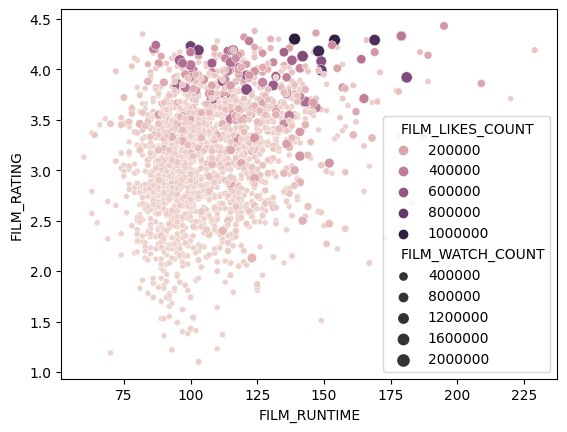

In [107]:
sns.scatterplot(data=df, x='FILM_RUNTIME', y='FILM_RATING', size='FILM_WATCH_COUNT', hue='FILM_LIKES_COUNT')

<Axes: xlabel='SCORE_BASIC', ylabel='SCORE_WEIGHTED'>

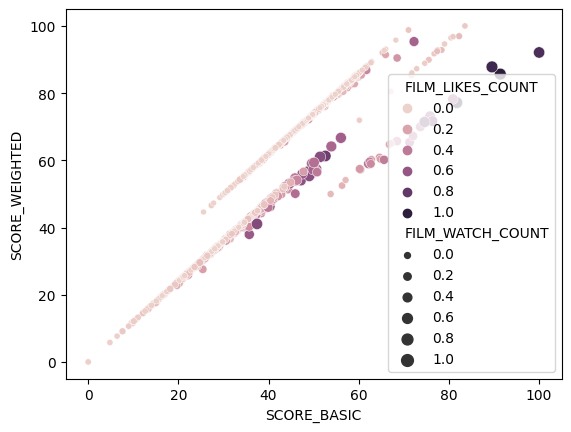

In [108]:
sns.scatterplot(data=df_scaled, x='SCORE_BASIC', y='SCORE_WEIGHTED', size='FILM_WATCH_COUNT', hue='FILM_LIKES_COUNT')

<Axes: xlabel='SCORE_WEIGHTED', ylabel='FILM_LIKES_COUNT'>

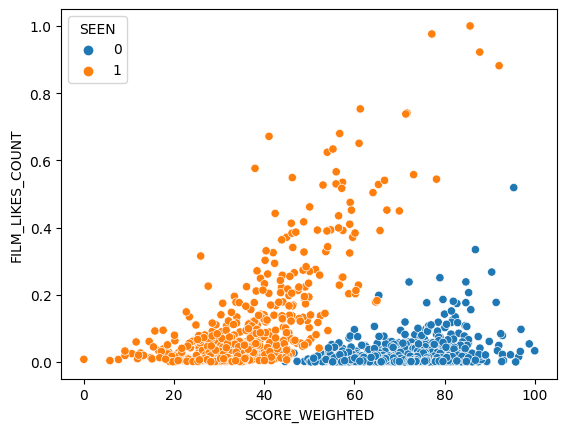

In [111]:
sns.scatterplot(data=df_scaled, x='SCORE_WEIGHTED', y='FILM_LIKES_COUNT', hue='SEEN')

<Axes: xlabel='FILM_RUNTIME', ylabel='FILM_WATCH_COUNT'>

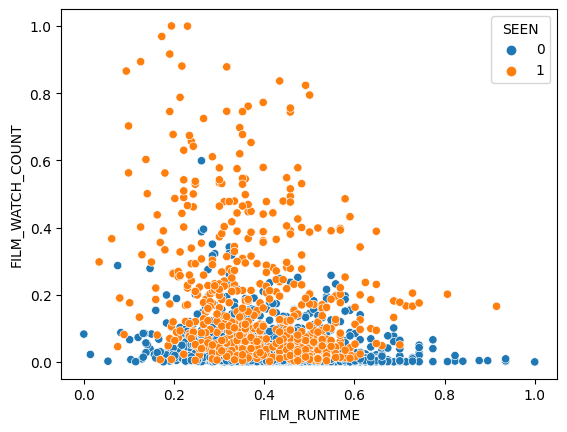

In [112]:
sns.scatterplot(data=df_scaled, x='FILM_RUNTIME', y='FILM_WATCH_COUNT', hue='SEEN')

In [120]:
df_scaled.sort_values('FILM_WATCH_COUNT', ascending=False).head(20)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE,SEEN_SCORE,SCORE_BASIC,SCORE_WEIGHTED
1453,f_01skk,Inception,1,1.000000,1,0.924925,0.922156,0.408345,Yes,0.194307,science-fiction,1.000000,0,89.547126,87.804339
1441,f_02a9q,Fight Club,1,0.999376,1,0.960961,1.000000,0.720804,Yes,0.229875,drama,0.695815,0,91.387903,85.659895
1435,f_029Pq,Pulp Fiction,1,0.968674,1,0.957958,0.976009,0.500840,Yes,0.172904,crime,0.591790,0,81.756798,77.171814
1476,f_09vEe,Avengers: Infinity War,1,0.916343,0,0.867868,0.753082,0.129128,Yes,0.190620,adventure,0.832756,0,52.597351,61.303582
1468,f_04VZ8,Interstellar,1,0.893618,1,0.957958,0.881585,1.000000,Yes,0.126046,science-fiction,1.000000,0,100.000000,92.100658
1897,f_00728,Forrest Gump,1,0.880540,0,0.909910,0.671426,0.276072,Yes,0.217518,romance,0.000000,0,37.438123,41.073986
1477,f_03VH2,Guardians of the Galaxy,1,0.878163,0,0.810811,0.650736,0.048302,Yes,0.316886,adventure,0.832756,0,51.440721,61.042130
1473,f_09vE4,Avengers: Endgame,1,0.865689,0,0.846847,0.679721,0.138328,Yes,0.094151,adventure,0.832756,0,48.905660,56.747435
1481,f_018U8,The Truman Show,1,0.836148,1,0.927928,0.737849,0.298322,Yes,0.434308,comedy,0.387290,0,74.599146,71.407509
1494,f_01OEc,Up,1,0.823194,0,0.897898,0.540433,0.039348,Yes,0.491864,adventure,0.832756,0,56.042842,66.686869


In [119]:
df.sort_values('FILM_WATCH_COUNT', ascending=False).head(20)

,FILM_ID,FILM_TITLE,SEEN,FILM_WATCH_COUNT,FILM_TOP_250,FILM_RATING,FILM_LIKES_COUNT,FILM_FAN_COUNT,STREAMING,FILM_RUNTIME,FILM_GENRE,GENRE_SCORE
1453,f_01skk,Inception,1,2292605,225.0,4.18,926654,39861,Yes,148,science-fiction,0.054542
1441,f_02a9q,Fight Club,1,2291174,77.0,4.30,1004878,70362,Yes,139,drama,0.010263
1435,f_029Pq,Pulp Fiction,1,2220788,89.0,4.29,980770,48890,Yes,154,crime,-0.004879
1476,f_09vEe,Avengers: Infinity War,1,2100814,NaN,3.99,756756,12605,Yes,149,adventure,0.030197
1468,f_04VZ8,Interstellar,1,2048714,88.0,4.29,885885,97616,Yes,169,science-fiction,0.054542
1897,f_00728,Forrest Gump,1,2018733,NaN,4.13,674702,26949,Yes,142,romance,-0.091023
1477,f_03VH2,Guardians of the Galaxy,1,2013282,NaN,3.80,653911,4715,Yes,121,adventure,0.030197
1473,f_09vE4,Avengers: Endgame,1,1984684,NaN,3.92,683037,13503,Yes,181,adventure,0.030197
1481,f_018U8,The Truman Show,1,1916959,194.0,4.19,741448,29121,Yes,103,comedy,-0.034647
1494,f_01OEc,Up,1,1887261,NaN,4.09,543070,3841,Yes,96,adventure,0.030197


<Axes: xlabel='FILM_RATING', ylabel='FILM_FAN_COUNT'>

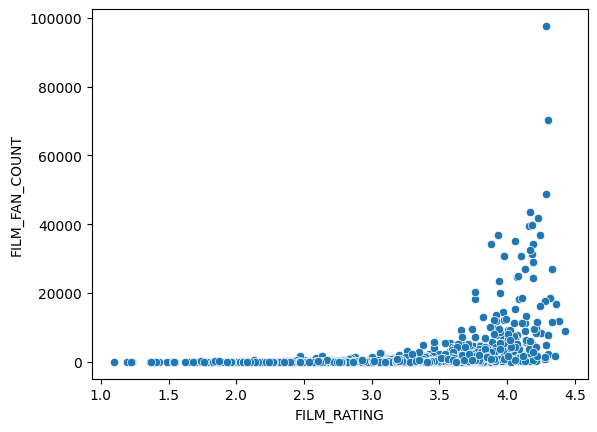

In [98]:
sns.scatterplot(data=df, x='FILM_RATING', y='FILM_FAN_COUNT')

<Axes: xlabel='FILM_WATCH_COUNT', ylabel='Count'>

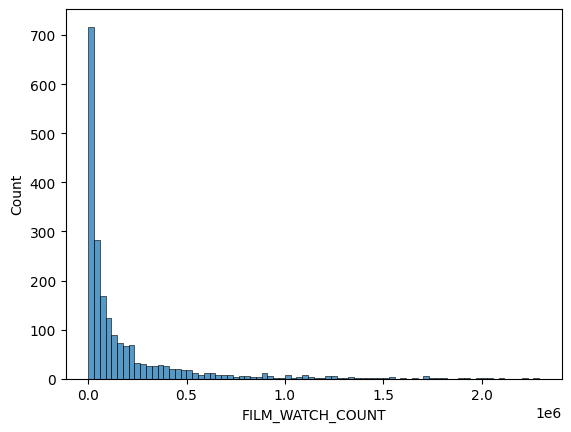

In [79]:
sns.histplot(df['FILM_WATCH_COUNT'])

In [4]:
rating_query = """

SELECT

	 a.FILM_ID
	,c.FILM_TITLE
	,d.FILM_GENRE
	,e.FILM_RATING
	,f.FILM_RATING_SCALED
	,f.FILM_RATING_SCALED - e.FILM_RATING AS RATING_VAR
	,ABS(f.FILM_RATING_SCALED - e.FILM_RATING) AS RATING_ABS_VAR

FROM ALL_FILMS a
LEFT JOIN CONTENT_TYPE b
ON a.FILM_ID = b.FILM_ID
LEFT JOIN FILM_TITLE c
ON a.FILM_ID = c.FILM_ID
LEFT JOIN FILM_GENRE d
ON a.FILM_ID = d.FILM_ID
LEFT JOIN FILM_LETTERBOXD_STATS e
ON a.FILM_ID = e.FILM_ID
LEFT JOIN PERSONAL_RATING f
ON a.FILM_ID = f.FILM_ID

WHERE CONTENT_TYPE = 'movie'
AND f.FILM_RATING_SCALED IS NOT NULL

ORDER BY RATING_VAR DESC
"""
rating_df = select_statement_to_df(rating_query)
rating_df

,FILM_ID,FILM_TITLE,FILM_GENRE,FILM_RATING,FILM_RATING_SCALED,RATING_VAR,RATING_ABS_VAR
0,f_027Vc,Star Wars: Episode I - The Phantom Menace,action,2.82,4.844595,2.024595,2.024595
1,f_01TM6,Jason X,science-fiction,2.21,4.174000,1.964000,1.964000
2,f_027V2,Star Wars: Episode II - Attack of the Clones,action,2.73,4.668919,1.938919,1.938919
3,f_0fBkw,The Nun,thriller,2.18,4.038000,1.858000,1.858000
4,f_0cY7Y,Godzilla: King of the Monsters,science-fiction,2.82,4.601351,1.781351,1.781351
...,...,...,...,...,...,...,...
747,f_01Yye,You've Got Mail,romance,3.44,1.314516,-2.125484,2.125484
748,f_0gnfO,Mamma Mia! Here We Go Again,romance,3.52,1.379032,-2.140968,2.140968
749,f_01QWs,Adulthood,drama,3.04,0.858696,-2.181304,2.181304
750,f_09n98,Me Before You,drama,3.40,1.097826,-2.302174,2.302174


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


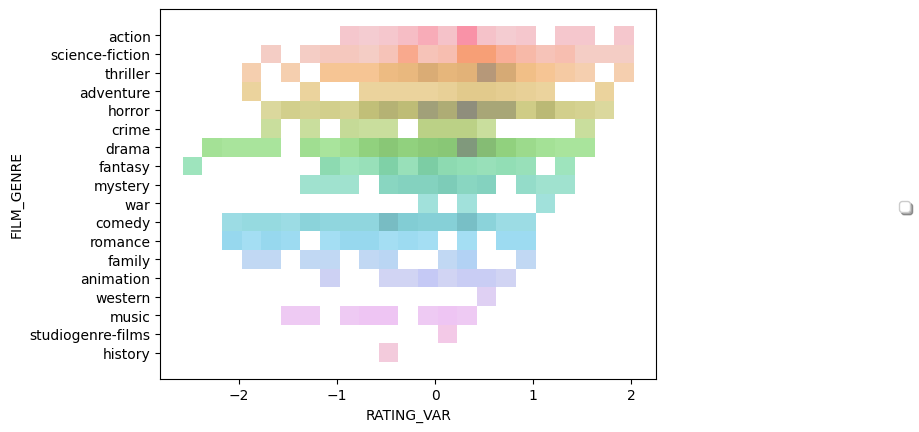

In [71]:
X_plot = np.linspace(0, 5, 100)
Y_plot = X_plot
sns.histplot(data=rating_df, x='RATING_VAR', y='FILM_GENRE', hue='FILM_GENRE', alpha=.66)
# plt.plot(X_plot, Y_plot, color='black', alpha=0.66)
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.5), ncol=3, fancybox=True, shadow=True)

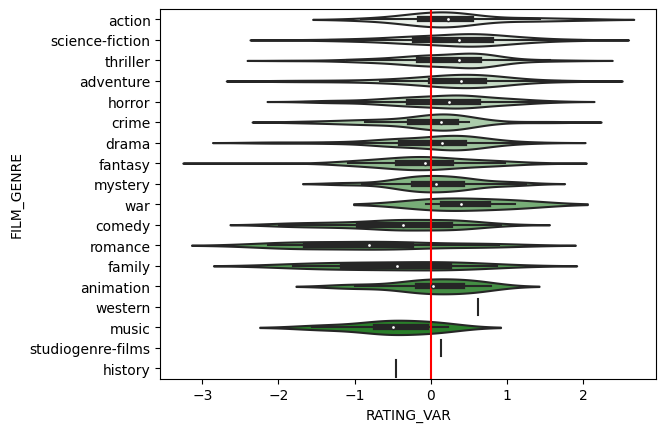

In [80]:
sns.violinplot(data=rating_df, x='RATING_VAR', y='FILM_GENRE', palette="light:g", orient="h")
plt.axvline(0, c='red')

In [19]:
rating_df_genre = rating_df.groupby('FILM_GENRE').agg({'FILM_RATING':'mean', 'FILM_RATING_SCALED':'mean', 'FILM_ID':'count'}).reset_index()
rating_df_genre

,FILM_GENRE,FILM_RATING,FILM_RATING_SCALED,FILM_ID
0,action,3.227857,3.518497,42
1,adventure,3.319565,3.563539,23
2,animation,3.692500,3.704565,16
3,comedy,3.373718,2.957717,78
4,crime,3.369130,3.310380,23
5,drama,3.651981,3.648703,106
6,family,3.151667,2.678337,12
7,fantasy,3.259500,3.140582,40
8,history,3.430000,2.978659,1
9,horror,3.074817,3.229155,164


5

C:\Users\tomdevine\AppData\Local\Temp\ipykernel_13672\3765123099.py:5: UserWarning: 
The palette list has fewer values (12) than needed (18) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=rating_df_genre, x='FILM_RATING', y='FILM_RATING_SCALED', hue='FILM_GENRE', size='FILM_ID', alpha=.66, sizes=(10, 500), palette=sns.color_palette("Paired"))


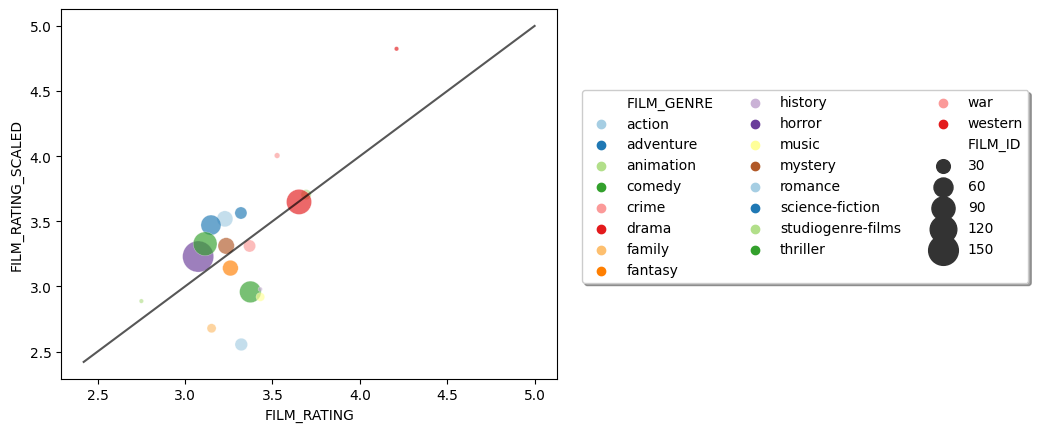

In [59]:
rating_min = int(100 * rating_df_genre[['FILM_RATING', 'FILM_RATING_SCALED']].min().min() * 0.95)/100
rating_max = min(int(100 * rating_df_genre[['FILM_RATING', 'FILM_RATING_SCALED']].max().max() * 1.05)/100, 5)
X_plot = np.linspace(rating_min, rating_max, 100)
Y_plot = X_plot
sns.scatterplot(data=rating_df_genre, x='FILM_RATING', y='FILM_RATING_SCALED', hue='FILM_GENRE', size='FILM_ID', alpha=.66, sizes=(10, 500), palette=sns.color_palette("Paired"))
plt.plot(X_plot, Y_plot, color='black', alpha=0.66)
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 0.8), ncol=3, fancybox=True, shadow=True)